# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [708]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [709]:
train = pd.read_csv('~/영화 관객수/movies_train.csv')
test = pd.read_csv('~/영화 관객수/movies_test.csv')

In [710]:
train.shape, test.shape

((600, 12), (243, 11))

In [711]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [712]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [713]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
train.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [714]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [715]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
test.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [716]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [717]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

Text(0.5, 1.0, 'Test - Missing')

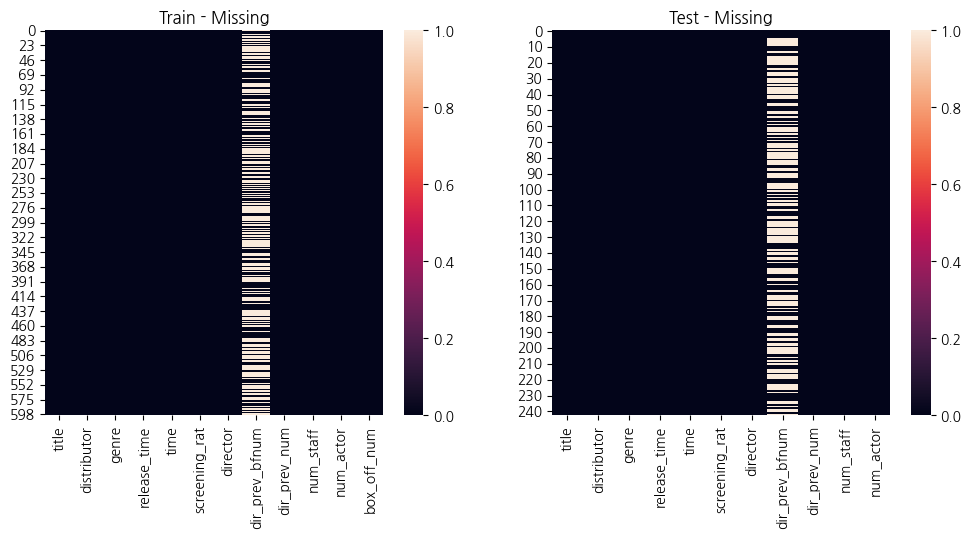

In [718]:
# 결측치를 시각화해봅니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(train.isnull(), ax=ax[0]).set_title("Train - Missing")
sns.heatmap(test.isnull(), ax=ax[1]).set_title("Test - Missing")

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [719]:
train["distributor"].unique()[:5]

array(['롯데엔터테인먼트', '(주)쇼박스', '(주)NEW', '쇼박스(주)미디어플렉스', '백두대간'],
      dtype=object)

In [720]:
# \(|주|\) 는 데이터에서 제거해줍니다
train["distributor"] = train["distributor"].str.replace("\(주\)", "")
test["distributor"] = test["distributor"].str.replace("\(주\)", "")

In [721]:
train["distributor"].unique()[:5]

array(['롯데엔터테인먼트', '쇼박스', 'NEW', '쇼박스미디어플렉스', '백두대간'], dtype=object)

Text(0.5, 1.0, 'Test - distributor')

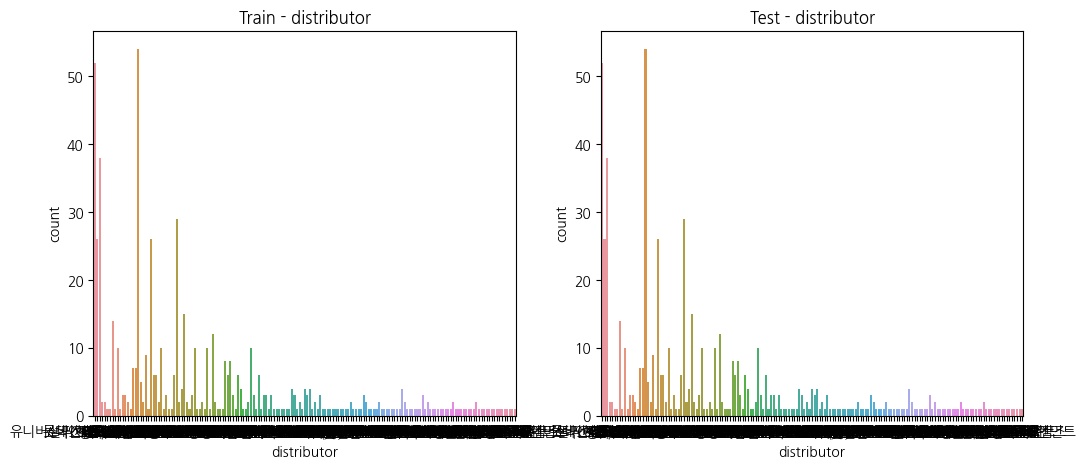

In [722]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=train, x='distributor', ax=ax[0]).set_title("Train - distributor")
sns.countplot(data=train, x='distributor', ax=ax[1]).set_title("Test - distributor")

In [723]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

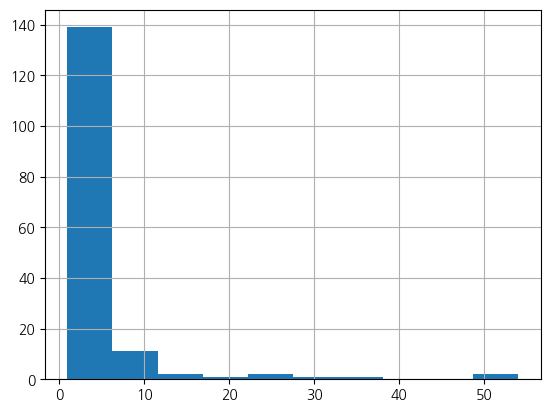

In [724]:
_ = train["distributor"].value_counts().hist()

In [725]:
train["distributor2"] = train["distributor"].copy()
train[["distributor", "distributor2"]].head()

,distributor,distributor2
0,롯데엔터테인먼트,롯데엔터테인먼트
1,쇼박스,쇼박스
2,쇼박스,쇼박스
3,NEW,NEW
4,쇼박스미디어플렉스,쇼박스미디어플렉스


In [726]:
df = pd.DataFrame(train["distributor2"].value_counts() > 15)
df.sample(5)

,distributor2
이상우필름,False
프리비젼엔터테인먼트,False
스폰지,False
콘텐츠판다,False
NEW,True


In [727]:
l = df[df["distributor2"] == True].index.tolist()
l

['CJ엔터테인먼트', '롯데엔터테인먼트', 'NEW', '마운틴픽쳐스', '인디스토리', '쇼박스', '시네마달']

In [728]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
train["distributor2"] = train["distributor"].copy()
def distributor_band(x):
    df = pd.DataFrame(train["distributor2"].value_counts() > 15)
    l = df[df["distributor2"] == True].index.tolist()
    if x in l:
        return "중대형"
    else:
        return "소형"

In [729]:
train["distributor"].apply(distributor_band).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [730]:
# 위 함수를 train과 test에 모두 적용합니다
train["distributor"] = train["distributor"].apply(distributor_band)
test["distributor"] = test["distributor"].apply(distributor_band)

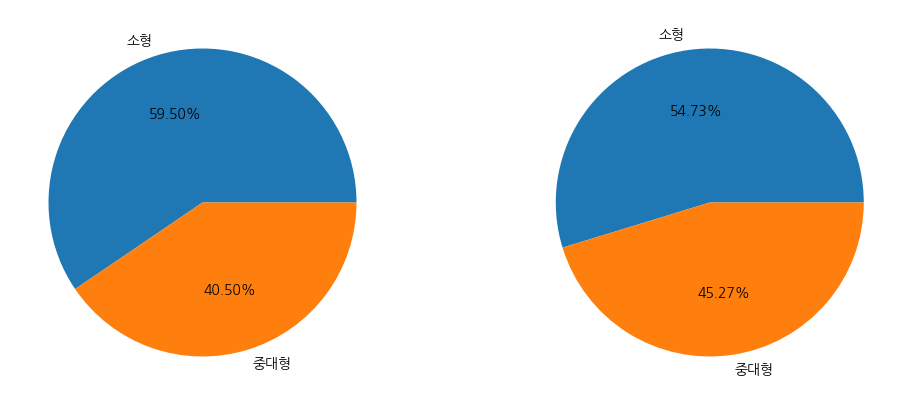

In [731]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

In [732]:
train = train.drop("distributor2", axis=1)

#### genre: 장르


In [733]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [734]:
rank_list = train.groupby("genre")["box_off_num"].mean().sort_values().index
rank_list

Index(['뮤지컬', '다큐멘터리', '서스펜스', '애니메이션', '멜로/로맨스', '미스터리', '공포', '드라마', '코미디',
       'SF', '액션', '느와르'],
      dtype='object', name='genre')

In [735]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다

In [736]:
num = 1
rank = {}

for genre in rank_list:
    rank[genre] = num
    num += 1

In [737]:
rank

{'뮤지컬': 1,
 '다큐멘터리': 2,
 '서스펜스': 3,
 '애니메이션': 4,
 '멜로/로맨스': 5,
 '미스터리': 6,
 '공포': 7,
 '드라마': 8,
 '코미디': 9,
 'SF': 10,
 '액션': 11,
 '느와르': 12}

In [738]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [739]:
train[["genre", "rank_genre"]].sample(10)

,genre,rank_genre
223,드라마,8
446,멜로/로맨스,5
537,공포,7
187,드라마,8
427,멜로/로맨스,5
25,드라마,8
481,드라마,8
324,드라마,8
516,액션,11
559,공포,7


In [740]:
test[["genre", "rank_genre"]].sample(10)

,genre,rank_genre
180,멜로/로맨스,5
193,멜로/로맨스,5
54,드라마,8
171,공포,7
59,드라마,8
0,느와르,12
38,드라마,8
212,드라마,8
3,액션,11
107,드라마,8


In [741]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train = train.drop('genre', axis=1)
test = test.drop('genre', axis=1)

In [742]:
display(train.head())
display(test.head())

,title,distributor,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre
0,개들의 전쟁,중대형,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,11
1,내부자들,중대형,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12
2,은밀하게 위대하게,중대형,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11
3,나는 공무원이다,중대형,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9
4,불량남녀,소형,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,9


,title,distributor,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre
0,용서는 없다,소형,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,12
1,아빠가 여자를 좋아해,중대형,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3,5
2,하모니,중대형,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7,8
3,의형제,중대형,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2,11
4,평행 이론,중대형,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1,7


### release_time: 개봉일

In [743]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train['release_time'] = pd.to_datetime(train["release_time"])
test['release_time'] = pd.to_datetime(test["release_time"])

In [744]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           600 non-null    object        
 1   distributor     600 non-null    object        
 2   release_time    600 non-null    datetime64[ns]
 3   time            600 non-null    int64         
 4   screening_rat   600 non-null    object        
 5   director        600 non-null    object        
 6   dir_prev_bfnum  270 non-null    float64       
 7   dir_prev_num    600 non-null    int64         
 8   num_staff       600 non-null    int64         
 9   num_actor       600 non-null    int64         
 10  box_off_num     600 non-null    int64         
 11  rank_genre      600 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 56.4+ KB


In [745]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   title           243 non-null    object        
 1   distributor     243 non-null    object        
 2   release_time    243 non-null    datetime64[ns]
 3   time            243 non-null    int64         
 4   screening_rat   243 non-null    object        
 5   director        243 non-null    object        
 6   dir_prev_bfnum  107 non-null    float64       
 7   dir_prev_num    243 non-null    int64         
 8   num_staff       243 non-null    int64         
 9   num_actor       243 non-null    int64         
 10  rank_genre      243 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 21.0+ KB


In [746]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train["year"] = train["release_time"].dt.year
train["month"] = train["release_time"].dt.month
train["day"] = train["release_time"].dt.day
train["dayofweek"] = train["release_time"].dt.dayofweek

In [747]:
test["year"] = test["release_time"].dt.year
test["month"] = test["release_time"].dt.month
test["day"] = test["release_time"].dt.day
test["dayofweek"] = test["release_time"].dt.dayofweek

In [748]:
# 기존 데이터는 삭제합니다
train = train.drop("release_time", axis=1)
test = test.drop("release_time", axis=1)

In [749]:
display(train.head())
display(test.head())

,title,distributor,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek
0,개들의 전쟁,중대형,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,11,2012,11,22,3
1,내부자들,중대형,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,2015,11,19,3
2,은밀하게 위대하게,중대형,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,2013,6,5,2
3,나는 공무원이다,중대형,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9,2012,7,12,3
4,불량남녀,소형,108,15세 관람가,신근호,1.00,1,251,2,483387,9,2010,11,4,3


,title,distributor,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre,year,month,day,dayofweek
0,용서는 없다,소형,125,청소년 관람불가,김형준,3.005290e+05,2,304,3,12,2010,1,7,3
1,아빠가 여자를 좋아해,중대형,113,12세 관람가,이광재,3.427002e+05,4,275,3,5,2010,1,14,3
2,하모니,중대형,115,12세 관람가,강대규,4.206611e+06,3,419,7,8,2010,1,28,3
3,의형제,중대형,116,15세 관람가,장훈,6.913420e+05,2,408,2,11,2010,2,4,3
4,평행 이론,중대형,110,15세 관람가,권호영,3.173800e+04,1,380,1,7,2010,2,18,3


<AxesSubplot:xlabel='dayofweek', ylabel='count'>

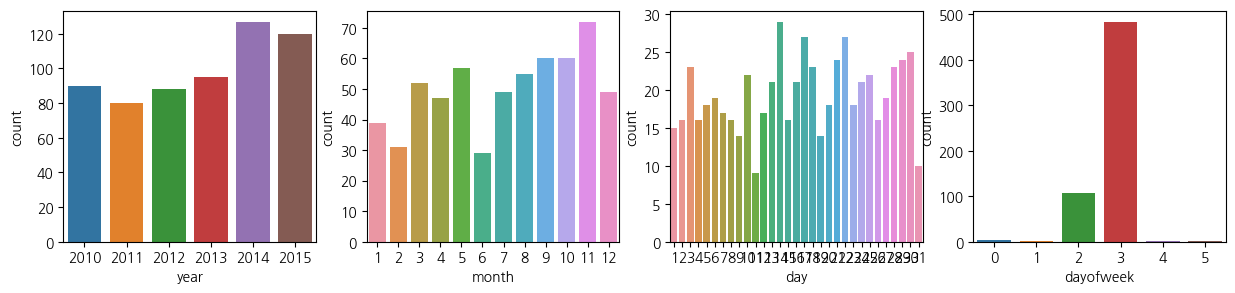

In [750]:
# 요일별로 시각화 해봅니다
fig, ax = plt.subplots(1, 4, figsize=(15, 3))
sns.countplot(data=train, x="year", ax=ax[0])
sns.countplot(data=train, x="month", ax=ax[1])
sns.countplot(data=train, x="day", ax=ax[2])
sns.countplot(data=train, x="dayofweek", ax=ax[3])

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [751]:
train.head()

,title,distributor,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek
0,개들의 전쟁,중대형,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,11,2012,11,22,3
1,내부자들,중대형,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,2015,11,19,3
2,은밀하게 위대하게,중대형,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,2013,6,5,2
3,나는 공무원이다,중대형,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9,2012,7,12,3
4,불량남녀,소형,108,15세 관람가,신근호,1.00,1,251,2,483387,9,2010,11,4,3


In [752]:
# 제목과 감독 데이터는 버려줍니다
train = train.drop(['title', 'director'], axis=1)
test = test.drop(['title', 'director'], axis=1)

In [753]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [754]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   time            600 non-null    int64  
 2   screening_rat   600 non-null    object 
 3   dir_prev_bfnum  600 non-null    float64
 4   dir_prev_num    600 non-null    int64  
 5   num_staff       600 non-null    int64  
 6   num_actor       600 non-null    int64  
 7   box_off_num     600 non-null    int64  
 8   rank_genre      600 non-null    int64  
 9   year            600 non-null    int64  
 10  month           600 non-null    int64  
 11  day             600 non-null    int64  
 12  dayofweek       600 non-null    int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 61.1+ KB


None

In [755]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [756]:
display(train.head())
display(test.head())

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek,distributor_소형,distributor_중대형,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,96,0.00,0,91,2,23398,11,2012,11,22,3,0,1,0,0,0,1
1,130,1161602.50,2,387,3,7072501,12,2015,11,19,3,0,1,0,0,0,1
2,123,220775.25,4,343,4,6959083,11,2013,6,5,2,0,1,0,1,0,0
3,101,23894.00,2,20,6,217866,9,2012,7,12,3,0,1,0,0,1,0
4,108,1.00,1,251,2,483387,9,2010,11,4,3,1,0,0,1,0,0


,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre,year,month,day,dayofweek,distributor_소형,distributor_중대형,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,125,3.005290e+05,2,304,3,12,2010,1,7,3,1,0,0,0,0,1
1,113,3.427002e+05,4,275,3,5,2010,1,14,3,0,1,1,0,0,0
2,115,4.206611e+06,3,419,7,8,2010,1,28,3,0,1,1,0,0,0
3,116,6.913420e+05,2,408,2,11,2010,2,4,3,0,1,0,1,0,0
4,110,3.173800e+04,1,380,1,7,2010,2,18,3,0,1,0,1,0,0


In [757]:
# 피처와 라벨을 구합니다
features = test.columns.tolist()
features

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

In [758]:
label = "box_off_num"
label

'box_off_num'

### Log Scale

In [759]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train["num_actor"] = np.log1p(train["num_actor"])

In [760]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [761]:
test.shape

(243, 16)

### Random Forest

In [762]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

rmse = mean_squared_error(y_val, y_predict) ** 0.5
rmse

1386163.907208716

<AxesSubplot:>

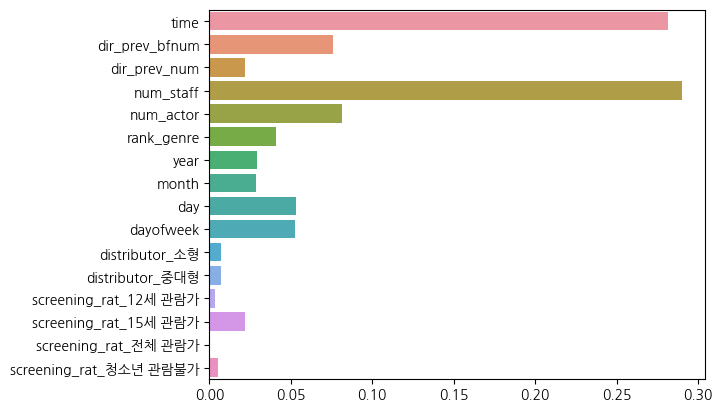

In [763]:
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)

### XGBoost

In [764]:
model = XGBRegressor(n_jobs=-1)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

rmse = mean_squared_error(y_val, y_predict) ** 0.5
rmse

1610437.8975140932

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

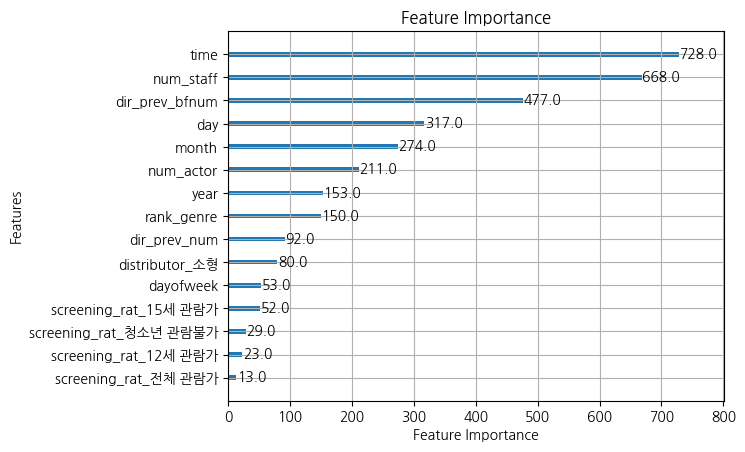

In [765]:
ax = xgb.plot_importance(model, max_num_features=len(features))
ax.set(title=f'Feature Importance',
    xlabel='Feature Importance',
    ylabel='Features')

### LightGBM

In [766]:
model = LGBMRegressor(n_jobs=-1)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

rmse = mean_squared_error(y_val, y_predict) ** 0.5
rmse

1483151.222553797

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Feature Importance'),
 Text(0, 0.5, 'Features')]

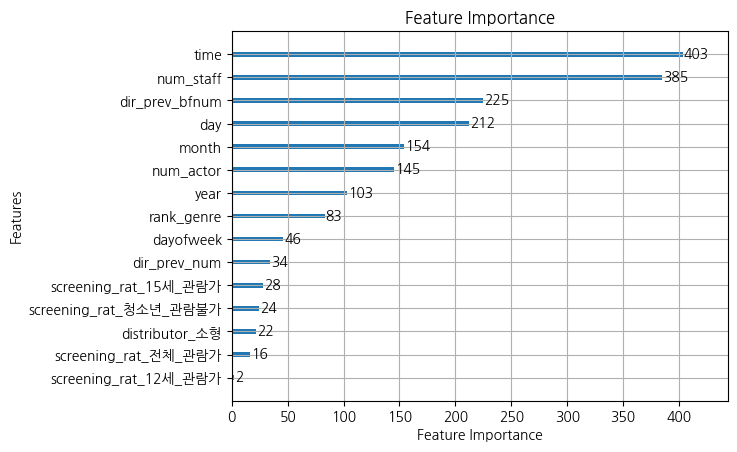

In [767]:
ax = lgbm.plot_importance(model, max_num_features=len(features), importance_type='auto')
ax.set(title=f'Feature Importance',
    xlabel='Feature Importance',
    ylabel='Features')